<a href="https://colab.research.google.com/github/javablack95/A_Guide_to_Running_Tensorflow_Models_on_Android/blob/master/Starter_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Starter Notebook - StatsSA

This notebook introduces the Zindi competition **Women in Big Data South Africa - Women-Headed Households in South Africa**. We'll take a quick look at the data, show how to create a model, estimate the score you'll get on Zindi, prepare your submission and get onto the leaderboard. I've also given some hints as to how to get a better score - once you have your first submission in, these might give you some ideas for what to try next.

# Loading the data
Make sure the CSV files provided by Zindi are in the same folder as this notebook. If it's running on Google Colab, you can use the 'files' tab on the left to upload them. We load the training data from Train.csv, and print out the variable descriptions here for easy reference. 

In [0]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

In [153]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [154]:
df = pd.read_csv('/content/Train.csv')
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,0.008080,0.002823,0.001431,0.008224,0,0,0.260191,0.607898,0.000188,0.010018,0.121705,0.283468,0.716532,0.273727,0.726273,0.118825,0.881175,0.832913,0.012336,0.001923,0.050939,0.000000,0.000564,0.076088,0.006371,0.003663,0.000375,0.000372,0.004943,0.002719,0,0.006793,0.357455,0.563166,0.004260,0.072996,0.002123,0.919424,0.742692,0.214027,0.019968,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,0.151910,0.001486,0.001253,0.008010,0,0,0.290228,0.549788,0.000000,0.021336,0.138647,0.103641,0.896359,0.144638,0.855362,0.066903,0.933097,0.879655,0.008445,0.000328,0.011249,0.000842,0.001759,0.032431,0.030844,0.001646,0.001308,0.000994,0.000000,0.002439,0,0.028061,0.698428,0.278006,0.003695,0.015835,0.004036,0.959259,0.309294,0.576844,0.018946,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,0.129902,0.000000,0.000000,0.004150,0,0,0.186435,0.677005,0.000489,0.021315,0.114757,0.165772,0.834228,0.272220,0.727780,0.100009,0.899991,0.565546,0.015991,0.001566,0.111270,0.004795,0.002552,0.148083,0.139687,0.003165,0.000165,0.000779,0.001692,0.002509,0,0.002200,0.672452,0.154225,0.002181,0.167494,0.003649,0.826164,0.323393,0.483376,0.083010,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,0.218786,0.000000,0.000000,0.002947,0,0,0.281229,0.593281,0.000579,0.007249,0.117663,0.087768,0.912232,0.127875,0.872125,0.029155,0.970845,0.743812,0.006530,0.001188,0.086423,0.006735,0.002308,0.103244,0.038284,0.003080,0.000582,0.000000,0.000197,0.007442,0,0.000174,0.728014,0.263831,0.001806,0.000956,0.005393,0.986151,0.677437,0.314194,0.002689,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,0.015382,0.008693,0.000000,0.000673,0,0,0.196687,0.517578,0.000989,0.005148,0.279598,0.345975,0.654025,0.404507,0.595493,0.133552,0.866448,0.422623,0.014352,0.000842,0.121869,0.007027,0.002613,0.147363,0.081706,0.003044,0.000169,0.000643,0.001201,0.004276,0,0.192272,0.753491,0.129654,0.004523,0.106953,0.005380,0.957376,0.771106,0.194743,0.009699,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [155]:
df.describe()

,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.0,2822.000000,2822.000000,2822.000000
mean,3665.281214,12869.130053,24.507554,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,0.064586,0.006864,0.001112,0.007902,0.0,0.0,0.311268,0.526568,0.000541,0.033694,0.127929,0.225922,0.774078,0.250312,0.749688,0.097637,0.902363,0.097603,0.058684,0.029416,0.039983,0.284316,0.116772,0.108053,0.130673,0.004621,0.024319,0.024262,0.053985,0.012809,0.0,0.014503,0.862142,0.040938,0.018798,0.074429,0.003693,0.836432,0.359691,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818,0.0,0.0,-26.880740,28.666515,17.437560
std,3266.364522,9696.690518,10.294387,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,0.109802,0.016819,0.003041,0.024762,0.0,0.0,0.076627,0.085116,0.000827,0.023375,0.036231,0.173811,0.173811,0.193682,0.193682,0.131082,0.131082,0.203996,0.123658,0.089490,0.083454,0.367565,0.255293,0.220157,0.260619,0.004607,0.117359,0.125629,0.161805,0.021413,0.0,0.040362,0.247392,0.142317,0.077927,0.169270,0.010813,0.203143,0.304472,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401,0.0,0.0,2.021279,2.373809,18.958621
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.001293,0.000000,0.000000,0.042789,0.000000,0.159514,0.000000,0.041328,0.000000,0.237387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-32.490089,16.760022,0.000000
25%,1778.858235,7071.205695,16.751556,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,0.002888,0.000233,0.000000,0.001991,0.0,0.0,0.255573,0.467217,0.000133,0.016981,0.110139,0.098199,0.696622,0.130976,0.718512,0.017315,0.879127,0.002842,0.009433,0.004081,0.001647,0.010344,0.001675,0.002681,0.003906,0.001675,0.000297,0.000300,0.000495,0.002589,0.0,0.000000,0.875275,0.001015,0.000877,0.000451,0.000664,0.796471,0.087638,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217,0.0,0.0,-28.569019,27.707932,3.033397
50%,2398.249935,9366.989680,24.156670,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,0.014991,0.001755,0.000391,0.004092,0.0,0.0,0.301668,0.540874,0.000338,0.027048,0.125760,0.172787,0.827213,0.178032,0.821968,0.040144,0.959856,0.007914,0.017589,0.008956,0.008835,0.052528,0.003986,0.017154,0.008403,0.003045,0.001267,0.001200,0.003261,0.006394,0.0,0.000146,0.989752,0.003124,0.001797,0.001208,0.001696,0.914060,0.277999,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165,0.0,0.0,-26.549866,28.959679,9.205572
75%,3987.080563,14241.233015,32.226553,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,0.074748,0.006507,0.001043,0.007803,0.0,0.0,0.371197,0.586087,0.000684,0.043500

In [0]:

df = df.loc[:, (df != 0).any(axis=0)]

In [157]:
df.shape

(2822, 58)

In [158]:
df.describe()

,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,3665.281214,12869.130053,24.507554,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,0.064586,0.006864,0.001112,0.007902,0.311268,0.526568,0.000541,0.033694,0.127929,0.225922,0.774078,0.250312,0.749688,0.097637,0.902363,0.097603,0.058684,0.029416,0.039983,0.284316,0.116772,0.108053,0.130673,0.004621,0.024319,0.024262,0.053985,0.012809,0.014503,0.862142,0.040938,0.018798,0.074429,0.003693,0.836432,0.359691,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818,-26.880740,28.666515,17.437560
std,3266.364522,9696.690518,10.294387,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,0.109802,0.016819,0.003041,0.024762,0.076627,0.085116,0.000827,0.023375,0.036231,0.173811,0.173811,0.193682,0.193682,0.131082,0.131082,0.203996,0.123658,0.089490,0.083454,0.367565,0.255293,0.220157,0.260619,0.004607,0.117359,0.125629,0.161805,0.021413,0.040362,0.247392,0.142317,0.077927,0.169270,0.010813,0.203143,0.304472,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401,2.021279,2.373809,18.958621
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001293,0.000000,0.000000,0.042789,0.000000,0.159514,0.000000,0.041328,0.000000,0.237387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.490089,16.760022,0.000000
25%,1778.858235,7071.205695,16.751556,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,0.002888,0.000233,0.000000,0.001991,0.255573,0.467217,0.000133,0.016981,0.110139,0.098199,0.696622,0.130976,0.718512,0.017315,0.879127,0.002842,0.009433,0.004081,0.001647,0.010344,0.001675,0.002681,0.003906,0.001675,0.000297,0.000300,0.000495,0.002589,0.000000,0.875275,0.001015,0.000877,0.000451,0.000664,0.796471,0.087638,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217,-28.569019,27.707932,3.033397
50%,2398.249935,9366.989680,24.156670,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,0.014991,0.001755,0.000391,0.004092,0.301668,0.540874,0.000338,0.027048,0.125760,0.172787,0.827213,0.178032,0.821968,0.040144,0.959856,0.007914,0.017589,0.008956,0.008835,0.052528,0.003986,0.017154,0.008403,0.003045,0.001267,0.001200,0.003261,0.006394,0.000146,0.989752,0.003124,0.001797,0.001208,0.001696,0.914060,0.277999,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165,-26.549866,28.959679,9.205572
75%,3987.080563,14241.233015,32.226553,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,0.074748,0.006507,0.001043,0.007803,0.371197,0.586087,0.000684,0.043500,0.139726,0.303378,0.901801,0.281488,0.869024,0.120873,0.982685,0.059328,0.036612,0.015081,0.039564,0.568497,0.055631,0.066745,0.065157,0.005782,0.006538,0.005247,0.029783,0.

In [159]:
var_desc = pd.read_csv('variable_descriptions.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or brick/concrete block structure on a separate stand or yard or on a farm,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apartment in a block of flats,NaN,NaN
3,dw_03,Percentage of dwellings of type: Cluster house in complex,NaN,NaN
4,dw_04,Percentage of dwellings of type: Townhouse (semi-detached house in a complex),NaN,NaN
5,dw_05,Percentage of dwellings of type: Semi-detached house,NaN,NaN
6,dw_06,Percentage of dwellings of type: House/flat/room in backyard,NaN,NaN
7,dw_07,Percentage of dwellings of type: Informal dwelling (shack,in backyard),NaN
8,dw_08,Percentage of dwellings of type: Informal dwelling (shack,not in backyard,e.g. in an informal/squatter settlement or on a farm)
9,dw_09,Percentage of dwellings of type: Room/flatlet on a property or larger dwelling/servants quarters/granny flat,NaN,NaN


# Quick EDA
Before we dive into modelling, let's take a quick look at the data and see what we have to work with. 

## Looking at the target variable
The purpose of this competition is to predict the percentage of households in a ward that are woman-headed and have an annual household income of <R19,600. To put that in context, that's less than 250USD per month. 

Text(0.5, 0, 'Percentage of households that are w-headed and have income under R19.6k/month')

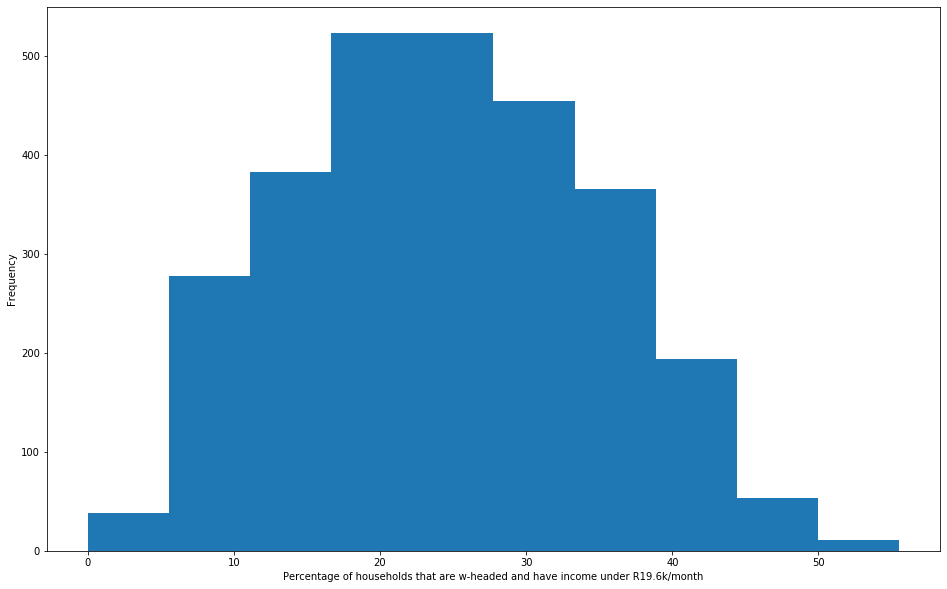

In [160]:
# Plot the distribution
ax = df['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month')

# Looking at a few interesting correlations

In [161]:
# Strong +ve correlations
df.corr()['target'].sort_values(ascending=False).head(10)

target    1.000000
psa_00    0.782472
car_01    0.702831
stv_01    0.664181
lln_01    0.637835
pg_00     0.613346
pw_06     0.470676
dw_01     0.458206
pw_02     0.442441
pw_03     0.440941
Name: target, dtype: float64

In [162]:

# And negative correlations
df.corr()['target'].sort_values().head(10)

pw_00    -0.754536
psa_01   -0.707506
car_00   -0.702831
stv_00   -0.664181
lln_00   -0.637835
pg_03    -0.583908
NL       -0.514398
lan_00   -0.507942
lan_01   -0.438704
dw_04    -0.385533
Name: target, dtype: float64

There are some high correlations here. Let's pick a few and investigate.

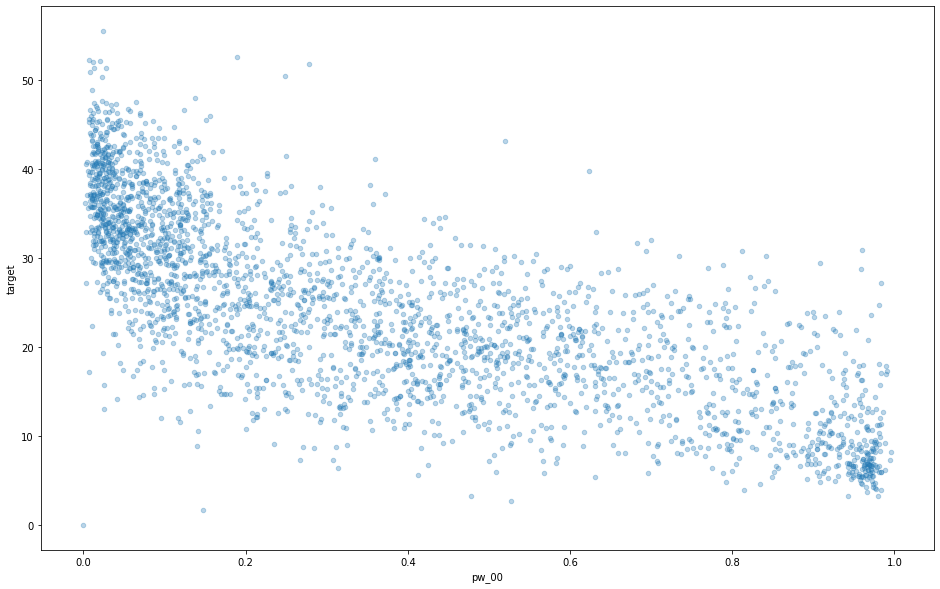

In [163]:

# pw_00: running water in the home. Places where almost everyone has piped water tend to be more affluent.
df.plot(x='pw_00', y='target', kind='scatter', alpha=0.3)

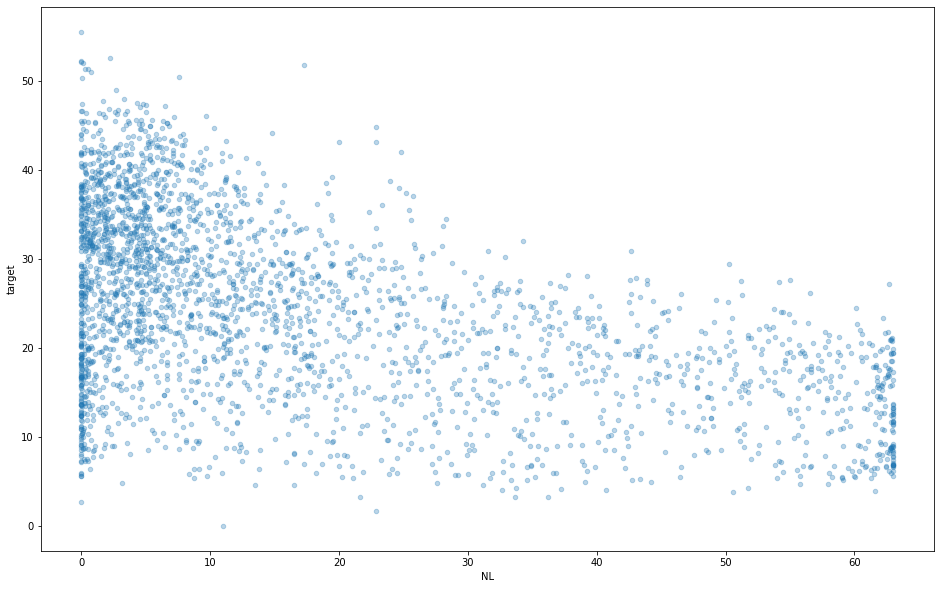

In [164]:
# Nightlights (NL)
df.plot(x='NL', y='target', kind='scatter', alpha=0.3)

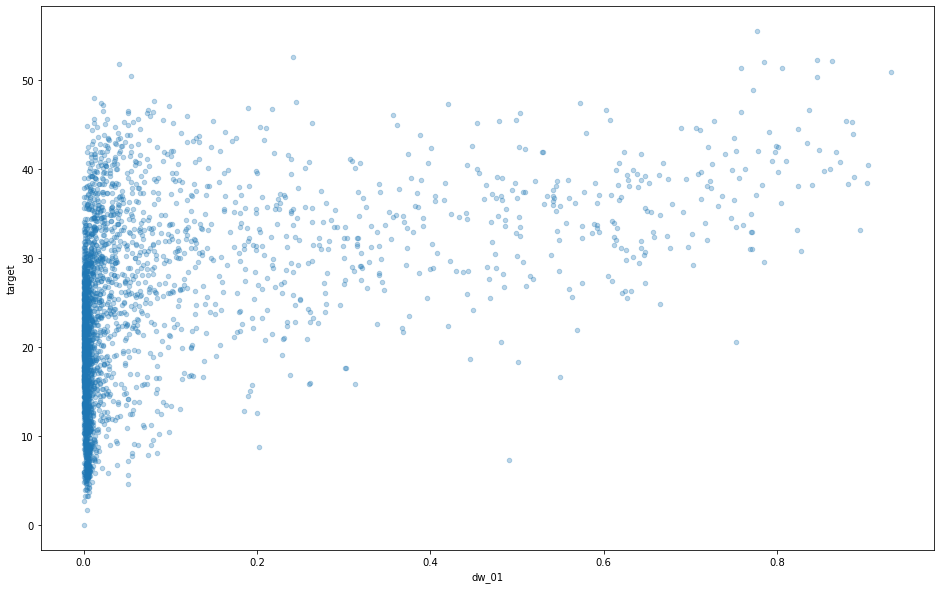

In [165]:
# dw_01: Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials
# Places where many of the buildings are 'traditional' tend to have more households 
# in the target category. 
df.plot(x='dw_01', y='target', kind='scatter', alpha=0.3)

Notice that for the dwelling type example above, the left hand side of the graph is chaotic. Fitting a straight line would tell part of the story, but to fully capture the trend we'd have to look at this data in conjunction with info on all the other dwelling types, and think about how trends might be different in rural vs urban areas. 

### Tip - Take a look at more of these variables and explore their relationships further. This will give you some extra insight that may come in handy for feature engineering. It's also an interesting exercise on it's own - this is data about South Africa, and South African people. ...

# Modelling
At this stage, most tutorials/notebooks would go into feature engineering. But I like to do a quick model FIRST, to see how tough the problem is and give us a baseline to compare to. So, in this section we'll try a simple linear model and then a more complicated Random Forest regressor, and set up a means to score our models locally (so that we don't have to keep submitting on Zindi).

In [166]:
# Define our input columns.
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
in_cols

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02',
       'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00',
       'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL'],
      dtype='object')

In [0]:
# Specify our target variable
ycol = 'target'

In [17]:
df[in_cols].shape

(2822, 53)

In [18]:
df[in_cols][:-1000].shape

(1822, 53)

In [19]:
# Fit a basic linear regression model, keeping the last 1000 rows for scoring
from sklearn.linear_model import LinearRegression, BayesianRidge
lm = LinearRegression()
bay = BayesianRidge()
lm.fit(df[in_cols][:-1000], df[ycol][:-1000])
bay.fit(df[in_cols][:-1000], df[ycol][:-1000])

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False)

### Evaluating Predictions

How do we evaluate our predictions? if we run `lm.score(df[in_cols][-1000:], df[ycol][-1000:])`, we'll get something called the 'R-Squared Score', which is a measure of how well our model explains the variation in the target variable. The closer to 1, the better. But this can be hard to visualize, so I like to plot predictions vs true values to get a better idea of how close our model is coming.

Neither of these tell us what our score on Zindi will look like. The metric used to evaluate submissions is RMSE - more info [here](https://www.statisticshowto.datasciencecentral.com/rmse/). 

Let's evaluate our first linear model:

In [20]:
lm.score(df[in_cols][-1000:], df[ycol][-1000:]) # R2 score
bay.score(df[in_cols][-1000:], df[ycol][-1000:])

0.17264538339469737

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]))))
print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], bay.predict(df[in_cols][-1000:]))))

RMSE: 29.72914559930966
RMSE: 8.681319628644141


Yikes! That seems bad? What is going on...

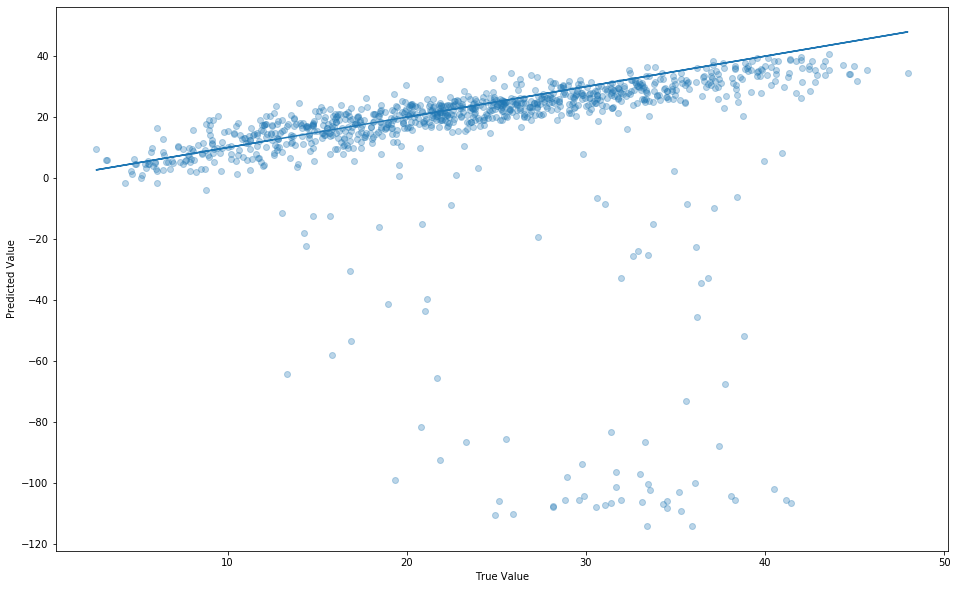

In [22]:
# Plot predicted vs actual
plt.scatter(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]), alpha=0.3)
plt.plot(df[ycol][-1000:], df[ycol][-1000:]) # A straight line - we want to be close to this
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

So the model is getting most predictions close to the mark, but some are waaaay off (causing the terrible score) and lots are negative! Let's move on to a better model.

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import NuSVR
from xgboost import XGBRegressor
import xgboost as xgb
from mlxtend.regressor import StackingRegressor 

In [0]:
stacking_bay_orig = StackingRegressor(
                    regressors=[BayesianRidge(), NuSVR()],
                    meta_regressor=RandomForestRegressor(n_estimators=100))

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train , X_test, y_train, y_test = train_test_split(df[in_cols],df[ycol] ,test_size = 0.25 )

In [28]:
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape)

(2116, 53) (2116,) (706, 53) (706,)


In [29]:
stacking_bay_orig.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


StackingRegressor(meta_regressor=RandomForestRegressor(bootstrap=True,
                                                       criterion='mse',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                       n_jobs=None,
                                                       oob_score=False,
                       

In [30]:
stacking_bay_orig.score(X_train,y_train) # Very good!

0.9792106484388771

In [31]:
stacking_bay_orig.score(X_test,y_test) # Very good!

0.8309458275893239

In [32]:
rf = RandomForestRegressor(n_estimators=100) # My go-to quick model for regression tasks.
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [33]:
rf.score(X_train,y_train) # Very good!

0.9838710387739223

In [34]:
rf.score(X_test,y_test) # Very good!

0.8740655053526505

In [35]:
print("RMSE:", sqrt(mean_squared_error(y_test, rf.predict(X_test))))

RMSE: 3.5958188691085353


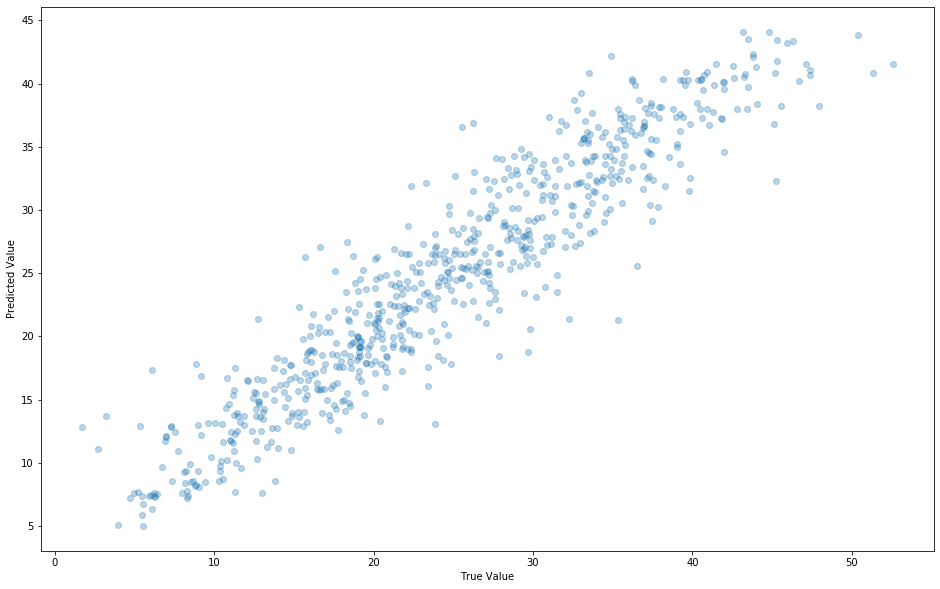

In [37]:
plt.scatter(y_test, rf.predict(X_test), alpha=0.3)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

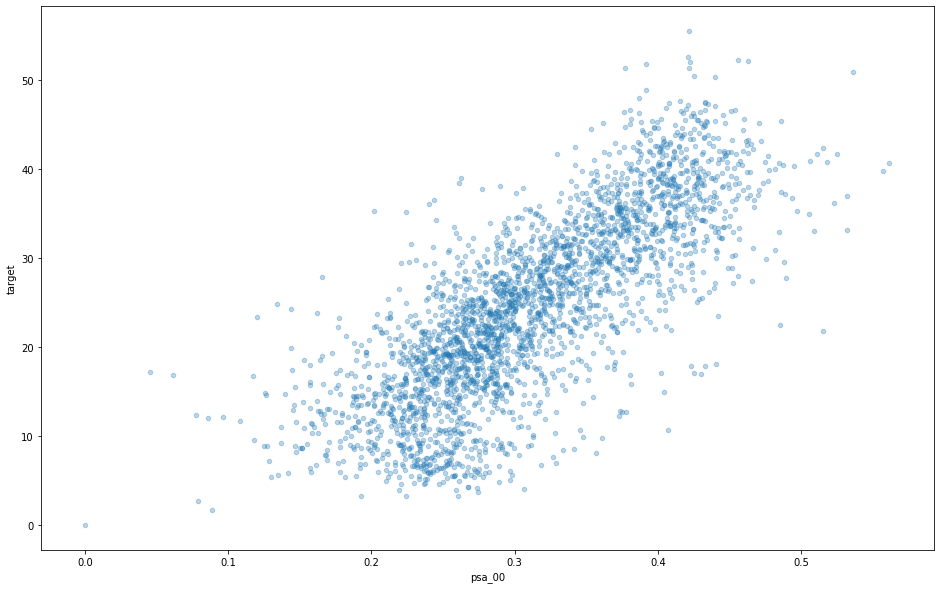

In [38]:
# It turns out school attendance is VERY informative!
df.plot(x='psa_00', y='target', kind='scatter', alpha=0.3)

In [0]:
from sklearn.metrics import *

### Better scoring with Cross-Validation

We could start tweaking model parameters and trying different models, using the code above to get the score. But this gives a score for just one split - we could pick a worse model that just happens to do well on the last 1000 rows. instead, we'll use something called k-fold cross validation to get a better estimate of how well one model does in relation to another.

In [39]:
from sklearn.model_selection import KFold

# Demonstrating splits
kf = KFold(n_splits=5, shuffle=False)
for train, test in kf.split(df):
  print(df.iloc[train].shape, df.iloc[test].shape)

(2257, 58) (565, 58)
(2257, 58) (565, 58)
(2258, 58) (564, 58)
(2258, 58) (564, 58)
(2258, 58) (564, 58)


In [40]:
# Using this to test a model on 5 different splits
kf = KFold(n_splits=5, shuffle=False)

scores = []
r2_scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  # r2 = rf.score(df[ycol].iloc[test].values, rf.predict(df[in_cols].iloc[test].values))
  scores.append(rmse)

  print(rmse)

print("Average rmse score in 5-fold CV:", np.mean(scores))
# print("Average r2 score in 5-fold CV:", np.mean(r2_scores))

3.8233117961531993
3.4752648882478754
4.643973741492391
4.320254579086219
3.9760384980575174
Average rmse score in 5-fold CV: 4.04776870060744


The wards are bits of land in South Africa. If we do a random split, we will have wards in the test set with adjacent wards in the training set. Since nearby locations are often similar, the model is able to make good guesses simply by looking at the neighbouring wards and extrapolating. But for this model to be useful, we want it to generalise well, so that we could potentially make predictions for now without doing ANY surveys. 

This is reflected in the way Zindi split the data - certain provinces are not represented at all in the training set. By splitting sequentially, we take advantage of the way the training set is ordered (by ward code) to do our own 'geographical' splits where adjacent regions are grouped together. 

So, use `shuffle=False` to get a better idea of what your model will score on Zindi.

### Tip: Sometimes a quick test/train split is enough to get an idea about how well something is doing, but when you're tuning parameters and comparing models it's worth the extra effort to do things rigorously. Try creating a score_model() function to make this quick and effortless going forward.

# FFast feature Engineering and Model Tuning

Let's add a new feature and tune our model a little bit, to see if we can beat our current score (4.01).

In [0]:
# Average household size - might contain some useful information
df['Household_Size'] = df['total_individuals']/df['total_households']

In [169]:
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
# ['Household_Size'].append(in_cols)

df.columns # Check that the new feature is included

Index(['ward', 'total_households', 'total_individuals', 'target', 'dw_00',
       'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07', 'dw_08',
       'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02', 'psa_03',
       'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00', 'lln_01',
       'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05', 'lan_06',
       'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12', 'lan_14',
       'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01',
       'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'ADM4_PCODE', 'lat', 'lon',
       'NL', 'Household_Size'],
      dtype='object')

In [170]:
in_cols

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02',
       'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00',
       'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL', 'Household_Size'],
      dtype='object')

In [171]:

df.columns.difference(in_cols)

Index(['ADM4_PCODE', 'target', 'total_households', 'total_individuals',
       'ward'],
      dtype='object')

In [44]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 4.048114866826167


In [45]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 4.0610173210874025


A small improvement, but every little bit helps!

### Tip: Spend some time on feature engineering. Look at ways to combine columns, or redundant info (percentage WITH car = 100- percentage without car, so perhaps one could be scrapped?). Check out extra sources of info. Can you use the coorinates to classify wards as Urban vs Rural? How about using the ward code to find the wards in the shapefile, and getting geographical area or coastline? For the very advanced, even satellite imagery might yield some useful info...

Let's try to tune the max_depth parameter in case our model is overfitting.

In [46]:
for md in [3, 4, 5, 7, 9, 12, 15]:
  scores = []
  for train, test in kf.split(df):
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
    rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
    scores.append(rmse)
  print("Average score in 5-fold CV:", np.mean(scores), "for max depth:", md)

Average score in 5-fold CV: 4.782384609364097 for max depth: 3
Average score in 5-fold CV: 4.469987148824554 for max depth: 4
Average score in 5-fold CV: 4.3505508324795645 for max depth: 5
Average score in 5-fold CV: 4.145920336577548 for max depth: 7
Average score in 5-fold CV: 4.091688577875131 for max depth: 9
Average score in 5-fold CV: 4.052969966347239 for max depth: 12
Average score in 5-fold CV: 4.03054167627184 for max depth: 15


Deeper models did better. 
### Tip: Try plotting score vs depth, and see where the model stops improving. You can also tune many other parameters

### Tip: Experiment with different models! There are many to choose from, and my favourite old Random Forest is feeling a little overwhelmed by the cool kids: XGBoost, LGBMs, NODE, 🐱boost...

# Making a submission

OK, so we have a model we're happy with. Now to make our submission. First, let's look at the submission format

In [47]:
pd.read_csv('SampleSubmission.csv').head()

,ward,target
0,21001001: Ward 1,21.87
1,21001002: Ward 2,65.94
2,21001003: Ward 3,83.65
3,21001004: Ward 4,NaN
4,21001005: Ward 5,NaN


For each ward, we need to predict the target. Let's do it

In [0]:
# Load the test data
test = pd.read_csv('Test.csv')
# Add any extra features just as we did for train
test['Household_Size'] = test['total_individuals']/test['total_households']

In [173]:
test

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,Household_Size
0,21001001: Ward 1,2504.95194,8745.15151,0.947257,0.000873,0.002021,0.000000,0.000000,0.030116,0.000452,0.013018,0.003516,0.000000,0.000668,0.002078,0.0,0.0,0.246694,0.615326,0.000000,0.016724,0.121257,0.155406,0.844594,0.216589,0.783411,0.173569,0.826431,0.817552,0.022885,0.000643,0.125655,0.000400,0.000125,0.002761,0.006069,0.000384,0.000131,0.000259,0.000000,0.004612,0.0,0.018525,0.173136,0.736099,0.003712,0.083467,0.003586,0.921001,0.551691,0.427445,0.012457,0.001757,0.000000,0.000000,0.006649,0.0,0.0,ZA2101001,-32.637758,23.848688,0.000000,3.491145
1,21001002: Ward 2,2080.27718,7258.11764,0.844993,0.000481,0.043629,0.004714,0.012323,0.012300,0.022132,0.022412,0.016969,0.006702,0.006492,0.006853,0.0,0.0,0.193484,0.532209,0.000936,0.052571,0.220800,0.406129,0.593871,0.498555,0.501445,0.366732,0.633268,0.434771,0.106254,0.000439,0.289230,0.001222,0.001483,0.002284,0.003142,0.001063,0.000162,0.000000,0.000000,0.005779,0.0,0.154172,0.471349,0.191902,0.002854,0.324584,0.009311,0.955494,0.759594,0.227192,0.009606,0.000691,0.000000,0.000000,0.002916,0.0,0.0,ZA2101002,-31.990536,24.555818,0.000000,3.489015
2,21001003: Ward 3,1106.62639,5919.13170,0.651380,0.007937,0.007113,0.000000,0.001977,0.259711,0.006505,0.044153,0.013530,0.000000,0.000000,0.007695,0.0,0.0,0.295614,0.499440,0.011465,0.078808,0.114673,0.237233,0.762767,0.190044,0.809956,0.090176,0.909824,0.953113,0.015398,0.000380,0.017653,0.000766,0.000190,0.002090,0.001140,0.003230,0.002241,0.000755,0.000000,0.003043,0.0,0.000000,0.079592,0.914919,0.001520,0.000549,0.003420,0.975955,0.704033,0.291719,0.001996,0.002253,0.000000,0.000000,0.000000,0.0,0.0,ZA2101003,-32.283595,24.563940,8.269556,5.348808
3,21001004: Ward 4,2175.56096,10280.57452,0.410837,0.002468,0.011511,0.000485,0.000000,0.449604,0.009256,0.101963,0.001516,0.009203,0.000000,0.003157,0.0,0.0,0.265445,0.519198,0.000000,0.014156,0.201201,0.343086,0.656914,0.348310,0.651690,0.248744,0.751256,0.852038,0.020889,0.000985,0.018133,0.000219,0.000552,0.000865,0.005020,0.000766,0.000000,0.000109,0.000000,0.001208,0.0,0.099216,0.102274,0.832795,0.006965,0.054769,0.003197,0.965817,0.556172,0.439729,0.002060,0.000000,0.000661,0.000000,0.001379,0.0,0.0,ZA2101004,-32.261612,24.542202,8.626625,4.725482
4,21001005: Ward 5,1270.83883,6018.34202,0.942851,0.002638,0.000821,0.000000,0.000891,0.000787,0.000830,0.027930,0.001617,0.017343,0.000000,0.004291,0.0,0.0,0.285008,0.552023,0.000187,0.053495,0.109287,0.255566,0.744434,0.182219,0.817781,0.137765,0.862235,0.965567,0.011856,0.000374,0.010614,0.001126,0.000000,0.001869,0.004672,0.000747,0.000000,0.000747,0.000000,0.002429,0.0,0.000000,0.033536,0.956602,0.007059,0.000000,0.002803,0.951707,0.444380,0.553173,0.000787,0.000000,0.000000,0.000000,0.001660,0.0,0.0,ZA2101005,-32.251571,24.558537,8.601754,4.735724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,19100107: Ward 107,16076.89903,43296.51372,0.668295,0.002827,0.207749,0.028813,0.069741,0.010701,0.003941,0.000804,0.002530,0.003673,0.000000,0.000926,0.0,0.0,0.233077,0.612635,0.000293,0.053580,0.100415,0.658908,0.341092,0.882464,0.117536,0.558145,0.441855,0.165559,0.608453,0.006922,0.074446,0.015429,0.003975,0.008570,0.008775,0.001703,0.002086,0.003400,0.002927,0.087869,0.0,0.009885,0.257872,0.079057,0.028981,0.619228,0.014863,0.996591,0.992238,0.004045,0.000609,0.000392,0.000291,0.000148,0.00227

In [49]:
# Fit a model on the whole training set, using our best parameters
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True, max_depth=7)
rf.fit(df[in_cols], df[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [50]:
# Make predictions
test['target'] = rf.predict(test[in_cols])
test.head()

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,dw_12,dw_13,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_13,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,Household_Size,target
0,21001001: Ward 1,2504.95194,8745.15151,0.947257,0.000873,0.002021,0.000000,0.000000,0.030116,0.000452,0.013018,0.003516,0.000000,0.000668,0.002078,0.0,0.0,0.246694,0.615326,0.000000,0.016724,0.121257,0.155406,0.844594,0.216589,0.783411,0.173569,0.826431,0.817552,0.022885,0.000643,0.125655,0.000400,0.000125,0.002761,0.006069,0.000384,0.000131,0.000259,0.0,0.004612,0.0,0.018525,0.173136,0.736099,0.003712,0.083467,0.003586,0.921001,0.551691,0.427445,0.012457,0.001757,0.000000,0.0,0.006649,0.0,0.0,ZA2101001,-32.637758,23.848688,0.000000,3.491145,19.958009
1,21001002: Ward 2,2080.27718,7258.11764,0.844993,0.000481,0.043629,0.004714,0.012323,0.012300,0.022132,0.022412,0.016969,0.006702,0.006492,0.006853,0.0,0.0,0.193484,0.532209,0.000936,0.052571,0.220800,0.406129,0.593871,0.498555,0.501445,0.366732,0.633268,0.434771,0.106254,0.000439,0.289230,0.001222,0.001483,0.002284,0.003142,0.001063,0.000162,0.000000,0.0,0.005779,0.0,0.154172,0.471349,0.191902,0.002854,0.324584,0.009311,0.955494,0.759594,0.227192,0.009606,0.000691,0.000000,0.0,0.002916,0.0,0.0,ZA2101002,-31.990536,24.555818,0.000000,3.489015,16.244125
2,21001003: Ward 3,1106.62639,5919.13170,0.651380,0.007937,0.007113,0.000000,0.001977,0.259711,0.006505,0.044153,0.013530,0.000000,0.000000,0.007695,0.0,0.0,0.295614,0.499440,0.011465,0.078808,0.114673,0.237233,0.762767,0.190044,0.809956,0.090176,0.909824,0.953113,0.015398,0.000380,0.017653,0.000766,0.000190,0.002090,0.001140,0.003230,0.002241,0.000755,0.0,0.003043,0.0,0.000000,0.079592,0.914919,0.001520,0.000549,0.003420,0.975955,0.704033,0.291719,0.001996,0.002253,0.000000,0.0,0.000000,0.0,0.0,ZA2101003,-32.283595,24.563940,8.269556,5.348808,24.961587
3,21001004: Ward 4,2175.56096,10280.57452,0.410837,0.002468,0.011511,0.000485,0.000000,0.449604,0.009256,0.101963,0.001516,0.009203,0.000000,0.003157,0.0,0.0,0.265445,0.519198,0.000000,0.014156,0.201201,0.343086,0.656914,0.348310,0.651690,0.248744,0.751256,0.852038,0.020889,0.000985,0.018133,0.000219,0.000552,0.000865,0.005020,0.000766,0.000000,0.000109,0.0,0.001208,0.0,0.099216,0.102274,0.832795,0.006965,0.054769,0.003197,0.965817,0.556172,0.439729,0.002060,0.000000,0.000661,0.0,0.001379,0.0,0.0,ZA2101004,-32.261612,24.542202,8.626625,4.725482,19.693254
4,21001005: Ward 5,1270.83883,6018.34202,0.942851,0.002638,0.000821,0.000000,0.000891,0.000787,0.000830,0.027930,0.001617,0.017343,0.000000,0.004291,0.0,0.0,0.285008,0.552023,0.000187,0.053495,0.109287,0.255566,0.744434,0.182219,0.817781,0.137765,0.862235,0.965567,0.011856,0.000374,0.010614,0.001126,0.000000,0.001869,0.004672,0.000747,0.000000,0.000747,0.0,0.002429,0.0,0.000000,0.033536,0.956602,0.007059,0.000000,0.002803,0.951707,0.444380,0.553173,0.000787,0.000000,0.000000,0.0,0.001660,0.0,0.0,ZA2101005,-32.251571,24.558537,8.601754,4.735724,22.817535


In [51]:
df.target.describe()

count    2822.000000
mean       24.507554
std        10.294387
min         0.000000
25%        16.751556
50%        24.156670
75%        32.226553
max        55.528423
Name: target, dtype: float64

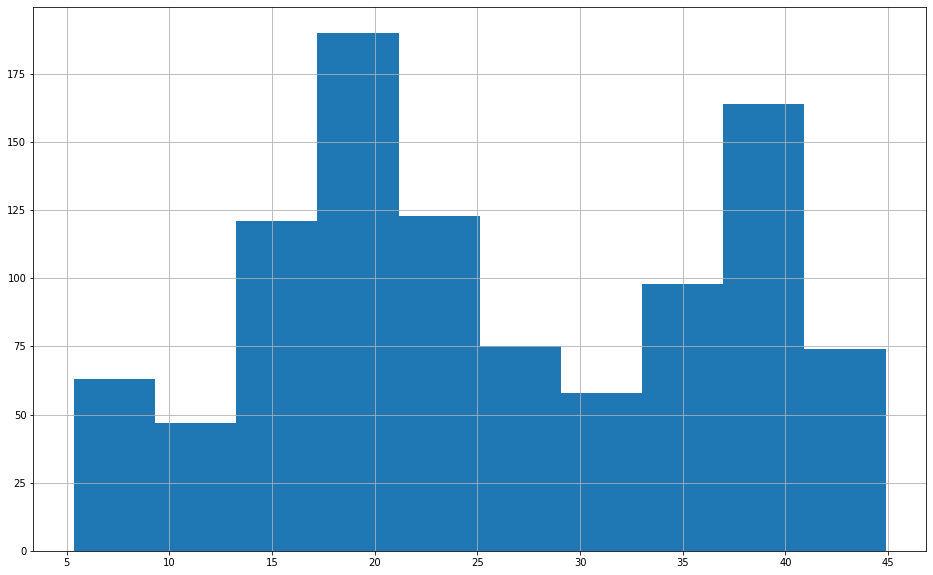

In [52]:
test.target.hist()

In [0]:
# Make predictions
test['target'] = stacking_bay_orig.predict(test[in_cols])
test.head()
# Save and submit!
test[['ward', 'target']].to_csv('starter5_nb_submission.csv', index=False)

And that's it! Upload your submission file to Zindi and see what you get :) If all works out well, you should get a score very similar to the one we got in our tests. That said, the test set includes Cape Town, so if your score is slightly lower than expected feel free to blame it on the DA ;)

#Further Analysis

In [174]:
df.tail()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,Household_Size
2817,34503001: Ward 1,3261.68067,11551.56486,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,0.017798,0.005539,0.010383,0.004955,0.003680,0.008020,0.249796,0.548069,0.000199,0.056862,0.145074,0.746483,0.253517,0.795676,0.204324,0.197108,0.802892,0.592857,0.056264,0.010778,0.012704,0.014871,0.007861,0.016431,0.222928,0.002182,0.001071,0.001738,0.005115,0.006115,0.049084,0.387404,0.212121,0.005720,0.389049,0.005706,0.977207,0.918325,0.074058,0.000472,0.000472,0.000472,0.000000,0.006203,ZA3453001,-27.675590,23.057920,9.118927,3.541599
2818,34503002: Ward 2,1463.06432,7908.90411,15.668000,0.636235,0.002262,0.010433,0.000000,0.003030,0.000000,0.008028,0.095099,0.210044,0.010001,0.003154,0.021716,0.243611,0.597921,0.000000,0.045679,0.112790,0.183194,0.816806,0.293898,0.706102,0.070786,0.929214,0.460575,0.014053,0.008162,0.004878,0.010016,0.003169,0.006027,0.480644,0.001125,0.000481,0.000443,0.001316,0.003419,0.005690,0.619593,0.299108,0.004645,0.067416,0.009238,0.970073,0.426518,0.557859,0.003467,0.003030,0.000713,0.000000,0.008414,ZA3453002,-27.591408,22.907161,1.697395,5.405712
2819,34503003: Ward 3,1395.18881,6242.37527,13.238795,0.855975,0.006601,0.061118,0.000812,0.003912,0.000812,0.017205,0.036566,0.008099,0.001102,0.000000,0.007797,0.253504,0.567502,0.001193,0.056393,0.121409,0.353950,0.646050,0.397152,0.602848,0.093775,0.906225,0.677660,0.051125,0.005620,0.010590,0.009532,0.001692,0.013570,0.149642,0.001556,0.001667,0.002614,0.002090,0.053578,0.019063,0.551808,0.381817,0.008169,0.030560,0.027646,0.965148,0.619392,0.326884,0.046445,0.002150,0.001458,0.000000,0.003670,ZA3453003,-27.952550,22.749698,2.792501,4.474215
2820,34503004: Ward 4,1679.66964,8014.73089,17.639523,0.792552,0.004423,0.016099,0.000000,0.000674,0.000000,0.006907,0.038522,0.116643,0.004255,0.014031,0.005894,0.272915,0.551838,0.000330,0.055723,0.119195,0.317836,0.682164,0.278854,0.721146,0.106750,0.893250,0.770298,0.019244,0.001279,0.012807,0.004833,0.001575,0.013318,0.105402,0.006628,0.000155,0.001061,0.001589,0.049083,0.012727,0.366426,0.533979,0.006260,0.054636,0.038698,0.890976,0.567853,0.301241,0.108998,0.009235,0.007870,0.000000,0.004803,ZA3453004,-27.913875,22.755314,2.793699,4.771611
2821,34503005: Ward 5,3008.38687,7899.36498,12.457680,0.254215,0.003310,0.121954,0.000000,0.001770,0.001023,0.014451,0.243248,0.308366,0.009663,0.007919,0.034081,0.164530,0.623015,0.000345,0.027009,0.185101,0.085743,0.914257,0.170296,0.829704,0.020633,0.979367,0.071158,0.026032,0.017735,0.015079,0.017721,0.007071,0.016372,0.667725,0.001945,0.001798,0.001681,0.010776,0.020720,0.124187,0.903506,0.059764,0.006687,0.019167,0.010876,0.680815,0.316055,0.666294,0.010805,0.003107,0.001636,0.000332,0.001770,ZA3453005,-27.741804,22.856933,0.001200,2.625781


In [175]:
df.describe()

,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,Household_Size
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,3665.281214,12869.130053,24.507554,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,0.064586,0.006864,0.001112,0.007902,0.311268,0.526568,0.000541,0.033694,0.127929,0.225922,0.774078,0.250312,0.749688,0.097637,0.902363,0.097603,0.058684,0.029416,0.039983,0.284316,0.116772,0.108053,0.130673,0.004621,0.024319,0.024262,0.053985,0.012809,0.014503,0.862142,0.040938,0.018798,0.074429,0.003693,0.836432,0.359691,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818,-26.880740,28.666515,17.437560,5.163249
std,3266.364522,9696.690518,10.294387,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,0.109802,0.016819,0.003041,0.024762,0.076627,0.085116,0.000827,0.023375,0.036231,0.173811,0.173811,0.193682,0.193682,0.131082,0.131082,0.203996,0.123658,0.089490,0.083454,0.367565,0.255293,0.220157,0.260619,0.004607,0.117359,0.125629,0.161805,0.021413,0.040362,0.247392,0.142317,0.077927,0.169270,0.010813,0.203143,0.304472,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401,2.021279,2.373809,18.958621,72.727066
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001293,0.000000,0.000000,0.042789,0.000000,0.159514,0.000000,0.041328,0.000000,0.237387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.490089,16.760022,0.000000,1.254742
25%,1778.858235,7071.205695,16.751556,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,0.002888,0.000233,0.000000,0.001991,0.255573,0.467217,0.000133,0.016981,0.110139,0.098199,0.696622,0.130976,0.718512,0.017315,0.879127,0.002842,0.009433,0.004081,0.001647,0.010344,0.001675,0.002681,0.003906,0.001675,0.000297,0.000300,0.000495,0.002589,0.000000,0.875275,0.001015,0.000877,0.000451,0.000664,0.796471,0.087638,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217,-28.569019,27.707932,3.033397,3.246975
50%,2398.249935,9366.989680,24.156670,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,0.014991,0.001755,0.000391,0.004092,0.301668,0.540874,0.000338,0.027048,0.125760,0.172787,0.827213,0.178032,0.821968,0.040144,0.959856,0.007914,0.017589,0.008956,0.008835,0.052528,0.003986,0.017154,0.008403,0.003045,0.001267,0.001200,0.003261,0.006394,0.000146,0.989752,0.003124,0.001797,0.001208,0.001696,0.914060,0.277999,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165,-26.549866,28.959679,9.205572,3.706505
75%,3987.080563,14241.233015,32.226553,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,0.074748,0.006507,0.001043,0.007803,0.371197,0.586087,0.000684,0.043500,0.139726,0.303378,0.901801,0.281488,0.869024,0.120873,0.982685,0.059328,0.036612,0.015081,0.039564,0

In [176]:
df[df.target == 0]

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,Household_Size
1815,93601011: Ward 11,1.0,3867.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.001293,0.0,0.0,0.998707,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001552,0.0,0.0,0.0,0.0,0.0,0.998448,0.952935,0.019136,0.006465,0.019912,0.001552,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,ZA9361011,-24.852036,27.349494,11.015128,3867.0


In [178]:
# df

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,Household_Size
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,0.008080,0.002823,0.001431,0.008224,0.260191,0.607898,0.000188,0.010018,0.121705,0.283468,0.716532,0.273727,0.726273,0.118825,0.881175,0.832913,0.012336,0.001923,0.050939,0.000000,0.000564,0.076088,0.006371,0.003663,0.000375,0.000372,0.004943,0.002719,0.006793,0.357455,0.563166,0.004260,0.072996,0.002123,0.919424,0.742692,0.214027,0.019968,0.002848,0.007537,0.000000,0.012928,ZA4161001,-29.682270,24.734743,0.292039,3.516501
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,0.151910,0.001486,0.001253,0.008010,0.290228,0.549788,0.000000,0.021336,0.138647,0.103641,0.896359,0.144638,0.855362,0.066903,0.933097,0.879655,0.008445,0.000328,0.011249,0.000842,0.001759,0.032431,0.030844,0.001646,0.001308,0.000994,0.000000,0.002439,0.028061,0.698428,0.278006,0.003695,0.015835,0.004036,0.959259,0.309294,0.576844,0.018946,0.014566,0.057127,0.019092,0.004131,ZA4161002,-29.119311,24.757737,3.207775,3.877587
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,0.129902,0.000000,0.000000,0.004150,0.186435,0.677005,0.000489,0.021315,0.114757,0.165772,0.834228,0.272220,0.727780,0.100009,0.899991,0.565546,0.015991,0.001566,0.111270,0.004795,0.002552,0.148083,0.139687,0.003165,0.000165,0.000779,0.001692,0.002509,0.002200,0.672452,0.154225,0.002181,0.167494,0.003649,0.826164,0.323393,0.483376,0.083010,0.057560,0.010358,0.001421,0.040881,ZA4161003,-29.142276,25.094093,0.000000,3.025929
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,0.218786,0.000000,0.000000,0.002947,0.281229,0.593281,0.000579,0.007249,0.117663,0.087768,0.912232,0.127875,0.872125,0.029155,0.970845,0.743812,0.006530,0.001188,0.086423,0.006735,0.002308,0.103244,0.038284,0.003080,0.000582,0.000000,0.000197,0.007442,0.000174,0.728014,0.263831,0.001806,0.000956,0.005393,0.986151,0.677437,0.314194,0.002689,0.000000,0.000669,0.000000,0.005011,ZA4161004,-29.372052,24.942867,2.038778,3.294194
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,0.015382,0.008693,0.000000,0.000673,0.196687,0.517578,0.000989,0.005148,0.279598,0.345975,0.654025,0.404507,0.595493,0.133552,0.866448,0.422623,0.014352,0.000842,0.121869,0.007027,0.002613,0.147363,0.081706,0.003044,0.000169,0.000643,0.001201,0.004276,0.192272,0.753491,0.129654,0.004523,0.106953,0.005380,0.957376,0.771106,0.194743,0.009699,0.004859,0.001290,0.000673,0.017629,ZA4161005,-29.409381,25.290165,0.000000,3.846971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,34503001: Ward 1,3261.68067,11551.56486,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,0.017798,0.005539,0.010383,0.004955,0.003680,0.008020,0.249796,0.548069,0.000199,0.056862,0.145074,0.746483,0.253517,0.795676,0.204324,0.197108,0.802892,0.592857,0.056264,0.010778,0.012704,0.014871,0.007861,0.016431,0.222928,0.002182,0.001071,0.001738,0.005115,0.006115,0.049084,0.387404,0.212121,0.005720,0.389049,0.005706,0.977207,0.918325,0.074058,0.000472,0.000472,0.000472,0.000000,0.006203,ZA3453001,-27.675590,23.057920,9.118927,3.541599
2818,34503002: Ward 2,1463.06432,7908.90411,15

In [262]:
df.ward.str.split(':')

0       [41601001,  Ward 1]
1       [41601002,  Ward 2]
2       [41601003,  Ward 3]
3       [41601004,  Ward 4]
4       [41601005,  Ward 5]
               ...         
2817    [34503001,  Ward 1]
2818    [34503002,  Ward 2]
2819    [34503003,  Ward 3]
2820    [34503004,  Ward 4]
2821    [34503005,  Ward 5]
Name: ward, Length: 2822, dtype: object

In [0]:
df['ward_category'] = [x.split(':')[1] for x in df.ward]

In [270]:
df

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,Household_Size,ward_category
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,0.008080,0.002823,0.001431,0.008224,0.260191,0.607898,0.000188,0.010018,0.121705,0.283468,0.716532,0.273727,0.726273,0.118825,0.881175,0.832913,0.012336,0.001923,0.050939,0.000000,0.000564,0.076088,0.006371,0.003663,0.000375,0.000372,0.004943,0.002719,0.006793,0.357455,0.563166,0.004260,0.072996,0.002123,0.919424,0.742692,0.214027,0.019968,0.002848,0.007537,0.000000,0.012928,ZA4161001,-29.682270,24.734743,0.292039,3.516501,Ward 1
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,0.151910,0.001486,0.001253,0.008010,0.290228,0.549788,0.000000,0.021336,0.138647,0.103641,0.896359,0.144638,0.855362,0.066903,0.933097,0.879655,0.008445,0.000328,0.011249,0.000842,0.001759,0.032431,0.030844,0.001646,0.001308,0.000994,0.000000,0.002439,0.028061,0.698428,0.278006,0.003695,0.015835,0.004036,0.959259,0.309294,0.576844,0.018946,0.014566,0.057127,0.019092,0.004131,ZA4161002,-29.119311,24.757737,3.207775,3.877587,Ward 2
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,0.129902,0.000000,0.000000,0.004150,0.186435,0.677005,0.000489,0.021315,0.114757,0.165772,0.834228,0.272220,0.727780,0.100009,0.899991,0.565546,0.015991,0.001566,0.111270,0.004795,0.002552,0.148083,0.139687,0.003165,0.000165,0.000779,0.001692,0.002509,0.002200,0.672452,0.154225,0.002181,0.167494,0.003649,0.826164,0.323393,0.483376,0.083010,0.057560,0.010358,0.001421,0.040881,ZA4161003,-29.142276,25.094093,0.000000,3.025929,Ward 3
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,0.218786,0.000000,0.000000,0.002947,0.281229,0.593281,0.000579,0.007249,0.117663,0.087768,0.912232,0.127875,0.872125,0.029155,0.970845,0.743812,0.006530,0.001188,0.086423,0.006735,0.002308,0.103244,0.038284,0.003080,0.000582,0.000000,0.000197,0.007442,0.000174,0.728014,0.263831,0.001806,0.000956,0.005393,0.986151,0.677437,0.314194,0.002689,0.000000,0.000669,0.000000,0.005011,ZA4161004,-29.372052,24.942867,2.038778,3.294194,Ward 4
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,0.015382,0.008693,0.000000,0.000673,0.196687,0.517578,0.000989,0.005148,0.279598,0.345975,0.654025,0.404507,0.595493,0.133552,0.866448,0.422623,0.014352,0.000842,0.121869,0.007027,0.002613,0.147363,0.081706,0.003044,0.000169,0.000643,0.001201,0.004276,0.192272,0.753491,0.129654,0.004523,0.106953,0.005380,0.957376,0.771106,0.194743,0.009699,0.004859,0.001290,0.000673,0.017629,ZA4161005,-29.409381,25.290165,0.000000,3.846971,Ward 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2817,34503001: Ward 1,3261.68067,11551.56486,6.393480,0.874972,0.003146,0.017230,0.004735,0.048888,0.000654,0.017798,0.005539,0.010383,0.004955,0.003680,0.008020,0.249796,0.548069,0.000199,0.056862,0.145074,0.746483,0.253517,0.795676,0.204324,0.197108,0.802892,0.592857,0.056264,0.010778,0.012704,0.014871,0.007861,0.016431,0.222928,0.002182,0.001071,0.001738,0.005115,0.006115,0.049084,0.387404,0.212121,0.005720,0.389049,0.005706,0.977207,0.918325,0.074058,0.000472,0.000472,0.000472,0.000000,0.006203,ZA3453001,-27.675590,23.057920,9.118927,3.

In [271]:
df.ward_category.value_counts()

 Ward 2      144
 Ward 1      144
 Ward 3      144
 Ward 4      144
 Ward 5      129
            ... 
 Ward 128      1
 Ward 115      1
 Ward 121      1
 Ward 124      1
 Ward 107      1
Name: ward_category, Length: 130, dtype: int64

In [95]:
for x in range(len(df[:10])):
  print(x)
  # df.ward = df.ward.str.split(':')[x][1]

0
1
2
3
4
5
6
7
8
9


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 60 columns):
ward                 2822 non-null object
total_households     2822 non-null float64
total_individuals    2822 non-null float64
target               2822 non-null float64
dw_00                2822 non-null float64
dw_01                2822 non-null float64
dw_02                2822 non-null float64
dw_03                2822 non-null float64
dw_04                2822 non-null float64
dw_05                2822 non-null float64
dw_06                2822 non-null float64
dw_07                2822 non-null float64
dw_08                2822 non-null float64
dw_09                2822 non-null float64
dw_10                2822 non-null float64
dw_11                2822 non-null float64
psa_00               2822 non-null float64
psa_01               2822 non-null float64
psa_02               2822 non-null float64
psa_03               2822 non-null float64
psa_04               2822 non-null

In [0]:
df.ward_category = df["ward_category"].astype('category')  

In [0]:
df.ward_category = df.ward_category.cat.codes

In [0]:
# df_trn, y_trn, nas = proc_df(df, 'target')

In [285]:
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,ADM4_PCODE,lat,lon,NL,Household_Size,ward_category
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,0.008080,0.002823,0.001431,0.008224,0.260191,0.607898,0.000188,0.010018,0.121705,0.283468,0.716532,0.273727,0.726273,0.118825,0.881175,0.832913,0.012336,0.001923,0.050939,0.000000,0.000564,0.076088,0.006371,0.003663,0.000375,0.000372,0.004943,0.002719,0.006793,0.357455,0.563166,0.004260,0.072996,0.002123,0.919424,0.742692,0.214027,0.019968,0.002848,0.007537,0.000000,0.012928,ZA4161001,-29.682270,24.734743,0.292039,3.516501,0
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,0.151910,0.001486,0.001253,0.008010,0.290228,0.549788,0.000000,0.021336,0.138647,0.103641,0.896359,0.144638,0.855362,0.066903,0.933097,0.879655,0.008445,0.000328,0.011249,0.000842,0.001759,0.032431,0.030844,0.001646,0.001308,0.000994,0.000000,0.002439,0.028061,0.698428,0.278006,0.003695,0.015835,0.004036,0.959259,0.309294,0.576844,0.018946,0.014566,0.057127,0.019092,0.004131,ZA4161002,-29.119311,24.757737,3.207775,3.877587,42
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,0.129902,0.000000,0.000000,0.004150,0.186435,0.677005,0.000489,0.021315,0.114757,0.165772,0.834228,0.272220,0.727780,0.100009,0.899991,0.565546,0.015991,0.001566,0.111270,0.004795,0.002552,0.148083,0.139687,0.003165,0.000165,0.000779,0.001692,0.002509,0.002200,0.672452,0.154225,0.002181,0.167494,0.003649,0.826164,0.323393,0.483376,0.083010,0.057560,0.010358,0.001421,0.040881,ZA4161003,-29.142276,25.094093,0.000000,3.025929,53
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,0.218786,0.000000,0.000000,0.002947,0.281229,0.593281,0.000579,0.007249,0.117663,0.087768,0.912232,0.127875,0.872125,0.029155,0.970845,0.743812,0.006530,0.001188,0.086423,0.006735,0.002308,0.103244,0.038284,0.003080,0.000582,0.000000,0.000197,0.007442,0.000174,0.728014,0.263831,0.001806,0.000956,0.005393,0.986151,0.677437,0.314194,0.002689,0.000000,0.000669,0.000000,0.005011,ZA4161004,-29.372052,24.942867,2.038778,3.294194,64
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,0.015382,0.008693,0.000000,0.000673,0.196687,0.517578,0.000989,0.005148,0.279598,0.345975,0.654025,0.404507,0.595493,0.133552,0.866448,0.422623,0.014352,0.000842,0.121869,0.007027,0.002613,0.147363,0.081706,0.003044,0.000169,0.000643,0.001201,0.004276,0.192272,0.753491,0.129654,0.004523,0.106953,0.005380,0.957376,0.771106,0.194743,0.009699,0.004859,0.001290,0.000673,0.017629,ZA4161005,-29.409381,25.290165,0.000000,3.846971,75


In [286]:
df[ycol]

0       16.773757
1       21.496661
2       10.931425
3       23.119257
4       13.652252
          ...    
2817     6.393480
2818    15.668000
2819    13.238795
2820    17.639523
2821    12.457680
Name: target, Length: 2822, dtype: float64

In [0]:
in_cols =['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02',
       'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00',
       'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL', 'Household_Size']

In [0]:
in_cols = in_cols + ["ward_category"]

In [292]:
df[in_cols].describe()

,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,dw_08,dw_09,dw_10,dw_11,psa_00,psa_01,psa_02,psa_03,psa_04,stv_00,stv_01,car_00,car_01,lln_00,lln_01,lan_00,lan_01,lan_02,lan_03,lan_04,lan_05,lan_06,lan_07,lan_08,lan_09,lan_10,lan_11,lan_12,lan_14,pg_00,pg_01,pg_02,pg_03,pg_04,lgt_00,pw_00,pw_01,pw_02,pw_03,pw_04,pw_05,pw_06,lat,lon,NL,Household_Size,ward_category
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000
mean,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,0.064586,0.006864,0.001112,0.007902,0.311268,0.526568,0.000541,0.033694,0.127929,0.225922,0.774078,0.250312,0.749688,0.097637,0.902363,0.097603,0.058684,0.029416,0.039983,0.284316,0.116772,0.108053,0.130673,0.004621,0.024319,0.024262,0.053985,0.012809,0.014503,0.862142,0.040938,0.018798,0.074429,0.003693,0.836432,0.359691,0.329684,0.127555,0.041589,0.019655,0.011008,0.110818,-26.880740,28.666515,17.437560,5.163249,55.174344
std,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,0.109802,0.016819,0.003041,0.024762,0.076627,0.085116,0.000827,0.023375,0.036231,0.173811,0.173811,0.193682,0.193682,0.131082,0.131082,0.203996,0.123658,0.089490,0.083454,0.367565,0.255293,0.220157,0.260619,0.004607,0.117359,0.125629,0.161805,0.021413,0.040362,0.247392,0.142317,0.077927,0.169270,0.010813,0.203143,0.304472,0.236642,0.156400,0.057331,0.032926,0.023672,0.185401,2.021279,2.373809,18.958621,72.727066,32.020599
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001293,0.000000,0.000000,0.042789,0.000000,0.159514,0.000000,0.041328,0.000000,0.237387,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011053,0.000000,0.000000,0.000000,0.000000,0.001692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.490089,16.760022,0.000000,1.254742,0.000000
25%,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,0.002888,0.000233,0.000000,0.001991,0.255573,0.467217,0.000133,0.016981,0.110139,0.098199,0.696622,0.130976,0.718512,0.017315,0.879127,0.002842,0.009433,0.004081,0.001647,0.010344,0.001675,0.002681,0.003906,0.001675,0.000297,0.000300,0.000495,0.002589,0.000000,0.875275,0.001015,0.000877,0.000451,0.000664,0.796471,0.087638,0.111282,0.008673,0.002099,0.000715,0.000159,0.005217,-28.569019,27.707932,3.033397,3.246975,38.000000
50%,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,0.014991,0.001755,0.000391,0.004092,0.301668,0.540874,0.000338,0.027048,0.125760,0.172787,0.827213,0.178032,0.821968,0.040144,0.959856,0.007914,0.017589,0.008956,0.008835,0.052528,0.003986,0.017154,0.008403,0.003045,0.001267,0.001200,0.003261,0.006394,0.000146,0.989752,0.003124,0.001797,0.001208,0.001696,0.914060,0.277999,0.302130,0.069065,0.016496,0.005164,0.001459,0.025165,-26.549866,28.959679,9.205572,3.706505,50.000000
75%,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,0.074748,0.006507,0.001043,0.007803,0.371197,0.586087,0.000684,0.043500,0.139726,0.303378,0.901801,0.281488,0.869024,0.120873,0.982685,0.059328,0.036612,0.015081,0.039564,0.568497,0.055631,0.066745,0.065157,0.005782,0.006538,0.005247,0.029783,0.013722,0.012108,0.995618,0.012582,0.004883,0.041841,0.004126,0.964334,0.582946,0.508771,0.183384,0.058626,0.025055,0.009432,0.11663

In [293]:
df.shape

(2822, 60)

In [426]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 1000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df, n_trn)
X_train, X_valid = split_vals(df[in_cols], n_trn)
y_train, y_valid = split_vals(df[ycol], n_trn)

X_train.shape, y_train.shape, X_valid.shape

((1822, 55), (1822,), (1000, 55))

In [0]:
# y_train = np.log(y_train)

In [0]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [429]:

m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 707 ms, sys: 4.04 ms, total: 711 ms
Wall time: 413 ms
[1.5557117061152574, 4.372900347796516, 0.9786667153866151, 0.7900773196742256]


In [430]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[4.839992283249159, 5.410991545691541, 0.7935148485161649, 0.678579248159848]


In [0]:
# !pip install fastai==0.7.0 > null

In [431]:

m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[9.943758433473234e-06, 5.723086405881069, 0.9999999999991285, 0.6404321878592136]


In [432]:


m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.5086993607980388, 4.466374748387612, 0.9799365829434991, 0.7810068549009929]


In [0]:

preds = np.stack([t.predict(X_valid) for t in m.estimators_])


In [434]:
preds.shape

(10, 1000)

In [435]:
preds[:,0]

array([20.66846, 28.99417, 30.01441, 30.9315 , 32.79594, 28.99417, 34.44096, 28.13116, 31.88653, 17.97744])

In [0]:
from sklearn import *

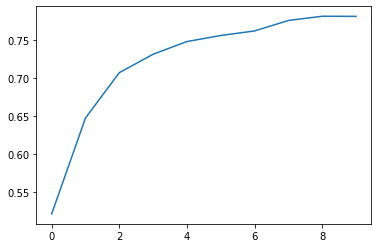

In [437]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);


The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [438]:

m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.4211192190809814, 4.19571564203242, 0.9821983395139965, 0.8067443073222554]


In [439]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.3521860334528806, 4.119974767166129, 0.9838834388657572, 0.8136586170735718]


In [440]:

m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.3179745659764865, 4.137999017251087, 0.9846886477810483, 0.8120246213850498]


In [441]:

m = RandomForestRegressor(n_estimators=100, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[1.2895800442621794, 4.08817701438022, 0.9853412784198162, 0.8165238636947101]


In [442]:

m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.2915538971953031, 4.079153678247807, 0.9852963703053141, 0.8173328990073296, 0.8918218072589977]


In [0]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [444]:

m = RandomForestRegressor(n_estimators=80, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.2747957961618726, 4.132174359238356, 0.9856754583830122, 0.8125534381895415, 0.8973443512184046]


In [0]:
t=m.estimators_[0].tree_

In [446]:
dectree_max_depth(t)

23

In [447]:

m = RandomForestRegressor(n_estimators=80, min_samples_leaf=4, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.8155073234504882, 4.119646849945048, 0.970946698001563, 0.8136882784769525, 0.8913955655039206]


In [0]:
t=m.estimators_[0].tree_

In [449]:
dectree_max_depth(t)

17

In [456]:

m = RandomForestRegressor(n_estimators=80, min_samples_leaf=2, n_jobs=-1, oob_score=True, max_depth=23)
m.fit(X_train, y_train)
print_score(m)

[1.4145893415444961, 4.0443878167458855, 0.9823615567875424, 0.8204333052364603, 0.8957334886229327]


In [455]:

m = RandomForestRegressor(n_estimators=80, min_samples_leaf=2, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.4355038772604252, 4.126602914400283, 0.9818361365685364, 0.8130585689206493, 0.8915931784010926]


In [453]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.6631277228778982, 4.082354694925613, 0.975619046057535, 0.8170460993888417, 0.8922339656896876]


In [461]:
m = RandomForestRegressor(n_estimators=80, min_samples_leaf=2, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.4676307947726035, 4.068785775722575, 0.9810140155928533, 0.8182602815162106, 0.8930715016472806]


In [0]:
from sklearn.model_selection import *

In [102]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf =RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features='sqrt', n_jobs=-1, oob_score=True)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 4.176253549048993


In [385]:

print (" Installing FastAI libraries...")
!pip install fastai==0.7.0 

 Installing FastAI libraries...
  Using cached https://files.pythonhosted.org/packages/50/6d/9d0d6e17a78b0598d5e8c49a0d03ffc7ff265ae62eca3e2345fab14edb9b/fastai-0.7.0-py3-none-any.whl
Processing /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745/bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/c2/d4/fe7e2637975c476734fcbf53776e650a29680194eb0dd21dbdc020ca92de/isoweek-1.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f5/20/865d4785f86e86f7ad7ebd52fc14810ef59ef13cd959f1363a2615d1c665/pandas_summary-0.0.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5b/a5/e8b50b55b1abac9f1e3346c4242f1e42a82d368a8442cbd50c532922f6c4/torch-0.3.1-cp36-cp36m-manylinux1_x86_64.whl
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 0.3.1 which is incompatible.
  Found existing installation: fastai 1.0.59
    Uninstalling fastai-1.0.59:
      Succ

In [0]:

%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [463]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 42.6 ms, sys: 95.1 ms, total: 138 ms
Wall time: 215 ms


(28.57812086258749, 5.574289032286017)

In [464]:
fi = rf_feat_importance(m, df[in_cols]); fi[:10]

,cols,imp
12,psa_00,0.256092
43,pw_00,0.235413
20,car_01,0.107645
19,car_00,0.091611
13,psa_01,0.067782
21,lln_00,0.023609
22,lln_01,0.015814
37,pg_00,0.013813
17,stv_00,0.011805
18,stv_01,0.011342


In [465]:
fi.imp.describe()

count    55.000000
mean      0.018182
std       0.048988
min       0.001144
25%       0.001825
50%       0.003156
75%       0.008639
max       0.256092
Name: imp, dtype: float64

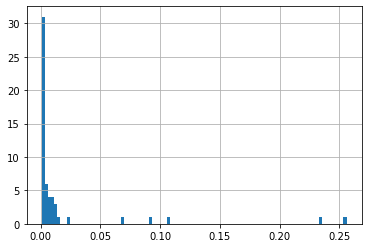

In [466]:
fi.imp.hist(bins= 100)

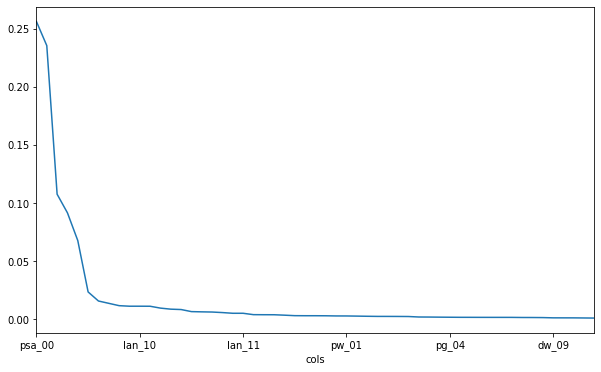

In [467]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [468]:
len(in_cols)

55

In [0]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

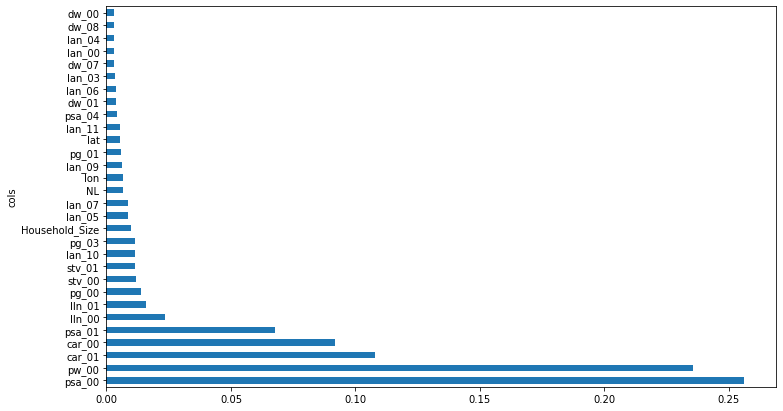

In [470]:
plot_fi(fi[:30]);

In [472]:

to_keep = fi[fi.imp>0.005].cols; len(to_keep)

21

In [0]:

df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [474]:
y_train

0       16.773757
1       21.496661
2       10.931425
3       23.119257
4       13.652252
          ...    
1817    15.440794
1818     9.528695
1819    14.571850
1820     8.912260
1821    10.424377
Name: target, Length: 1822, dtype: float64

In [475]:
X_train

,psa_00,pw_00,car_01,car_00,psa_01,lln_00,lln_01,pg_00,stv_00,stv_01,lan_10,pg_03,Household_Size,lan_05,lan_07,NL,lon,lan_09,pg_01,lat,lan_11
0,0.260191,0.742692,0.726273,0.273727,0.607898,0.118825,0.881175,0.357455,0.283468,0.716532,0.000372,0.072996,3.516501,0.000564,0.006371,0.292039,24.734743,0.000375,0.563166,-29.682270,0.004943
1,0.290228,0.309294,0.855362,0.144638,0.549788,0.066903,0.933097,0.698428,0.103641,0.896359,0.000994,0.015835,3.877587,0.001759,0.030844,3.207775,24.757737,0.001308,0.278006,-29.119311,0.000000
2,0.186435,0.323393,0.727780,0.272220,0.677005,0.100009,0.899991,0.672452,0.165772,0.834228,0.000779,0.167494,3.025929,0.002552,0.139687,0.000000,25.094093,0.000165,0.154225,-29.142276,0.001692
3,0.281229,0.677437,0.872125,0.127875,0.593281,0.029155,0.970845,0.728014,0.087768,0.912232,0.000000,0.000956,3.294194,0.002308,0.038284,2.038778,24.942867,0.000582,0.263831,-29.372052,0.000197
4,0.196687,0.771106,0.595493,0.404507,0.517578,0.133552,0.866448,0.753491,0.345975,0.654025,0.000643,0.106953,3.846971,0.002613,0.081706,0.000000,25.290165,0.000169,0.129654,-29.409381,0.001201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817,0.212490,0.293718,0.814668,0.185332,0.592413,0.027289,0.972711,0.947343,0.257423,0.742577,0.028427,0.033327,3.403761,0.443039,0.260443,14.783899,27.651309,0.004421,0.010642,-23.655598,0.035779
1818,0.117712,0.550936,0.673355,0.326645,0.401245,0.026816,0.973184,0.928377,0.361216,0.638784,0.019354,0.036029,5.207654,0.318591,0.089558,19.053002,27.567892,0.002406,0.026482,-23.660914,0.019996
1819,0.126316,0.250036,0.807028,0.192972,0.720751,0.081772,0.918228,0.865888,0.170618,0.829382,0.013295,0.124520,3.781923,0.288534,0.262031,0.326532,27.429842,0.001858,0.003491,-23.677350,0.083145
1820,0.309244,0.919320,0.344148,0.655852,0.489270,0.217743,0.782257,0.540594,0.671566,0.328434,0.024589,0.434274,3.195824,0.234832,0.075090,12.352384,27.705752,0.003829,0.016238,-23.686227,0.020095


In [0]:

from scipy.cluster import hierarchy as hc

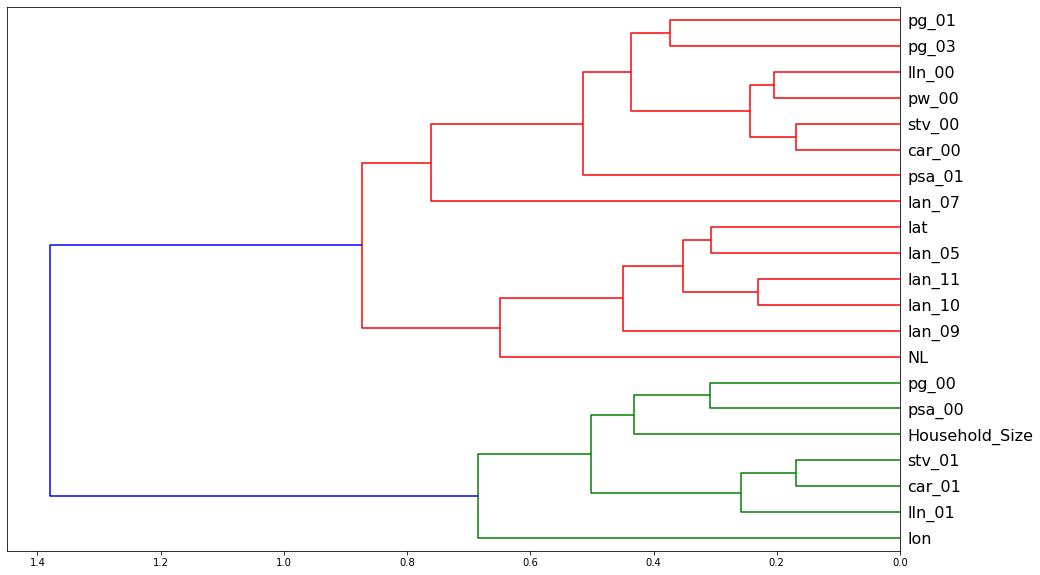

In [477]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [0]:
# in_cols

In [350]:
get_oob(df_keep)

0.8814649752179939

In [482]:
for c in ('stv_01','car_01'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

stv_01 0.8918895249398304
car_01 0.8841560350535258


In [0]:
to_drop = ['stv_01','car_01']

In [484]:
get_oob(df_keep.drop(to_drop, axis=1))

0.8864098962193919

In [485]:
df_keep.shape


(2822, 21)

In [0]:

df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [0]:
np.save('/keep_cols.npy', np.array(df_keep.columns))

In [0]:
keep_cols = np.load('/keep_cols.npy',allow_pickle=True)
df_keep = df[keep_cols]

In [490]:
df_keep.shape

(2822, 18)

In [0]:
reset_rf_samples()

In [492]:

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[1.5868615101185612, 4.094779797802484, 0.9778038556355972, 0.8159307232845449, 0.890557260642]


In [493]:

m = RandomForestRegressor(n_estimators=200, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.86 s, sys: 32.9 ms, total: 2.9 s
Wall time: 1.68 s
[1.2701828587906387, 4.058882211921516, 0.9857789395197414, 0.8191439261820179, 0.8969933193673266]


In [494]:

m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.38 s, sys: 14 ms, total: 2.4 s
Wall time: 1.33 s
[1.2650558398373961, 4.039909130951596, 0.98589351277872, 0.8208307831985676, 0.8969315666511897]


In [495]:

m = RandomForestRegressor(n_estimators=100, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.46 s, sys: 13 ms, total: 1.48 s
Wall time: 893 ms
[1.2892157868481975, 4.047102150107757, 0.985349558315165, 0.8201921970888456, 0.8956524808994408]


In [496]:

m = RandomForestRegressor(n_estimators=100, max_features=0.7, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1.95 s, sys: 9.97 ms, total: 1.96 s
Wall time: 1.09 s
[1.2762585964157185, 4.032824834603151, 0.9856425653263013, 0.8214586066913923, 0.8966805489724822]


In [497]:

m = RandomForestRegressor(n_estimators=160, max_features=0.9, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 3.99 s, sys: 10.9 ms, total: 4 s
Wall time: 2.13 s
[1.251389392158756, 4.102792686045575, 0.9861966523374331, 0.8152096248496956, 0.8986840134690975]


In [498]:
X_train.columns

Index(['psa_00', 'pw_00', 'car_00', 'psa_01', 'lln_00', 'lln_01', 'pg_00',
       'stv_00', 'lan_10', 'pg_03', 'Household_Size', 'lan_05', 'lan_07', 'NL',
       'lon', 'lan_09', 'pg_01', 'lat', 'lan_11'],
      dtype='object')

In [507]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf =RandomForestRegressor(n_estimators=160, max_features=0.9, n_jobs=-1, oob_score=True)
  rf.fit(df[X_train.columns].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[X_train.columns].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 3.9064300290117173


In [0]:
rf =RandomForestRegressor(n_estimators=160, max_features=0.9, n_jobs=-1, oob_score=True)

In [516]:
rf.fit(df[X_train.columns], df[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.9, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [510]:
X_train.columns

Index(['psa_00', 'pw_00', 'car_00', 'psa_01', 'lln_00', 'lln_01', 'pg_00',
       'stv_00', 'lan_10', 'pg_03', 'Household_Size', 'lan_05', 'lan_07', 'NL',
       'lon', 'lan_09', 'pg_01', 'lat', 'lan_11'],
      dtype='object')

In [512]:
test[X_train.columns]

,psa_00,pw_00,car_00,psa_01,lln_00,lln_01,pg_00,stv_00,lan_10,pg_03,Household_Size,lan_05,lan_07,NL,lon,lan_09,pg_01,lat,lan_11
0,0.246694,0.551691,0.216589,0.615326,0.173569,0.826431,0.173136,0.155406,0.000259,0.083467,3.491145,0.000125,0.006069,0.000000,23.848688,0.000131,0.736099,-32.637758,0.000000
1,0.193484,0.759594,0.498555,0.532209,0.366732,0.633268,0.471349,0.406129,0.000000,0.324584,3.489015,0.001483,0.003142,0.000000,24.555818,0.000162,0.191902,-31.990536,0.000000
2,0.295614,0.704033,0.190044,0.499440,0.090176,0.909824,0.079592,0.237233,0.000755,0.000549,5.348808,0.000190,0.001140,8.269556,24.563940,0.002241,0.914919,-32.283595,0.000000
3,0.265445,0.556172,0.348310,0.519198,0.248744,0.751256,0.102274,0.343086,0.000109,0.054769,4.725482,0.000552,0.005020,8.626625,24.542202,0.000000,0.832795,-32.261612,0.000000
4,0.285008,0.444380,0.182219,0.552023,0.137765,0.862235,0.033536,0.255566,0.000747,0.000000,4.735724,0.000000,0.004672,8.601754,24.558537,0.000000,0.956602,-32.251571,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,0.233077,0.992238,0.882464,0.612635,0.558145,0.441855,0.257872,0.658908,0.003400,0.619228,2.693089,0.003975,0.008775,33.913055,18.496094,0.002086,0.079057,-33.806524,0.002927
1009,0.248120,0.433723,0.136133,0.577557,0.021517,0.978483,0.955210,0.070309,0.001250,0.000531,3.064533,0.003066,0.003006,60.009486,18.673308,0.000527,0.036253,-33.982120,0.002885
1010,0.239656,0.733120,0.295191,0.534385,0.181138,0.818862,0.248422,0.187296,0.000680,0.010415,4.260171,0.000936,0.004033,35.834860,18.767457,0.000234,0.727472,-34.062704,0.000803
1011,0.203364,0.934310,0.532806,0.530802,0.488726,0.511274,0.058357,0.320743,0.000255,0.003929,4.547948,0.000463,0.002822,50.153301,18.487893,0.000423,0.911192,-34.057772,0.000206


In [0]:
# Make predictions
test['target'] = rf.predict(test[X_train.columns])
test.head()
# Save and submit!
test[['ward', 'target']].to_csv('starter9_nb_submission.csv', index=False)

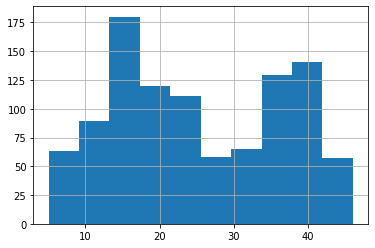

In [520]:
test.target.hist()

In [151]:
df[ycol].describe()

count    2822.000000
mean       24.507554
std        10.294387
min         0.000000
25%        16.751556
50%        24.156670
75%        32.226553
max        55.528423
Name: target, dtype: float64